In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split

df = pd.read_csv("assets/diabetic_data.csv")
X = df.drop(columns=["medical_specialty", "weight", "payer_code", "readmitted"])
y = df["readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)  # Should be (84142, N) where N is feature count
print(y_train.shape)  # Should be (84142,)

(81412, 46)
(81412,)


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_train["race"] = le.fit_transform(X_train["race"])
X_test["race"] = le.transform(X_test["race"])
X_train["gender"] = le.fit_transform(X_train["gender"])
X_test["gender"] = le.transform(X_test["gender"])

for col in ["diag_1", "diag_2", "diag_3"]:
    X_train[col] = pd.to_numeric(X_train[col], errors="coerce")
    X_test[col] = pd.to_numeric(X_test[col], errors="coerce")
    
X_train.replace("None", np.nan, inplace=True)
X_test.replace("None", np.nan, inplace=True)
X_train.replace("?", np.nan, inplace=True)
X_test.replace("?", np.nan, inplace=True)
X_train.fillna(1, inplace=True)
X_test.fillna(1, inplace=True)

age_mapping = {"[0-10)": 5, "[10-20)": 15, "[20-30)": 25, "[30-40)": 35, "[40-50)": 45, "[50-60)": 55,
               "[60-70)": 65, "[70-80)": 75, "[80-90)": 85, "[90-100)": 95}
X_train["age"] = X_train["age"].map(age_mapping)
X_test["age"] = X_test["age"].map(age_mapping)

mapping = {"No": 0, "Yes": 1, "Ch": -1, "Steady": 10, "Up": 100, "Down": -100}
medication_cols = [
    "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", 
    "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", 
    "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", 
    "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone", "change", "diabetesMed"
]

X_train[medication_cols] = X_train[medication_cols].replace(mapping)
X_test[medication_cols] = X_test[medication_cols].replace(mapping)

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5819003635649013
Classification Report:
               precision    recall  f1-score   support

         <30       0.44      0.01      0.03      2285
         >30       0.50      0.35      0.41      7117
          NO       0.61      0.85      0.71     10952

    accuracy                           0.58     20354
   macro avg       0.52      0.40      0.38     20354
weighted avg       0.55      0.58      0.53     20354



In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

X_train_reduced = SelectKBest(f_classif, k=20).fit_transform(X_train, y_train)
X_test_reduced = SelectKBest(f_classif, k=20).fit_transform(X_test, y_test)

rf = RandomForestClassifier(n_estimators=25, max_depth=10, min_samples_split=5, max_features="sqrt")

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

param_grid = {
    'n_estimators': [25, 50],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

Features [36 37] are constant.
invalid value encountered in true_divide
Features [26 34 36 37 41 42 43] are constant.
invalid value encountered in true_divide


Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}


Confusion Matrix:
 [[   3  764 1518]
 [   1 2340 4776]
 [   0 1281 9671]]
ROC-AUC Score: 0.6824020984696954


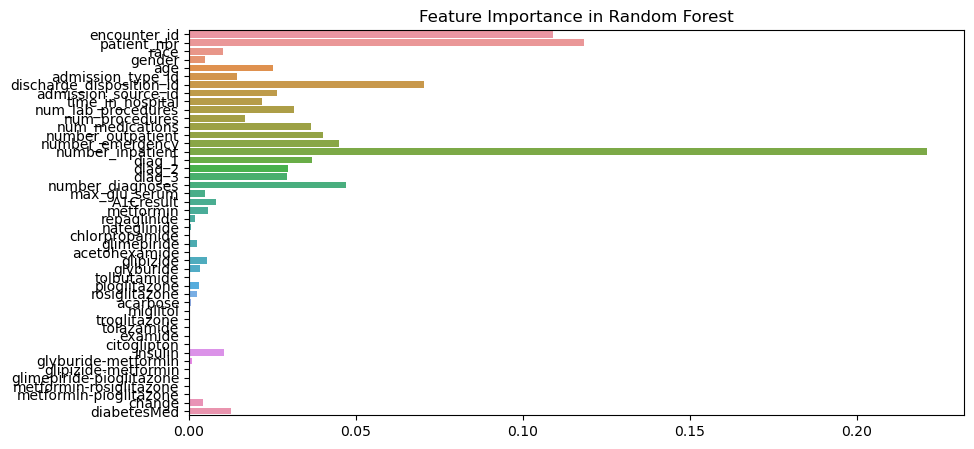

In [4]:
from sklearn.metrics import confusion_matrix, roc_auc_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test), multi_class="ovr"))

feature_importances = rf.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10,5))
sns.barplot(x=feature_importances, y=feature_names)
plt.title("Feature Importance in Random Forest")
plt.show()


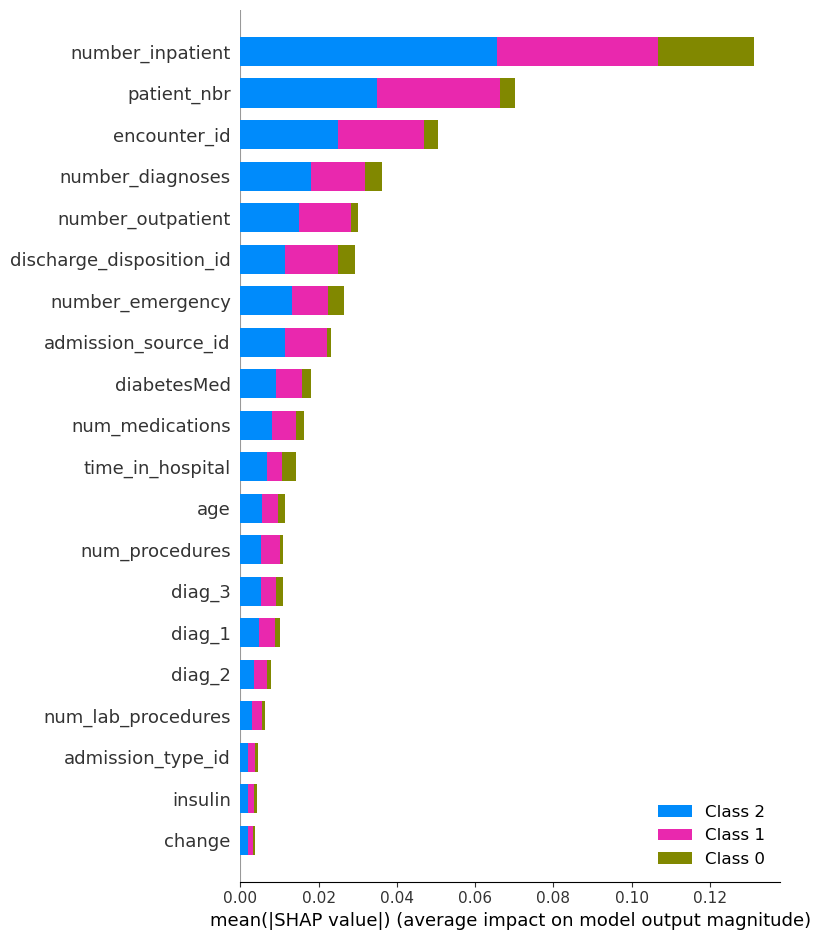

In [5]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)